In [452]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import timedelta
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

from PIL import Image

In [453]:
taxi = pd.read_parquet('cab_nyc.parquet', engine='pyarrow')
rideshare = pd.read_parquet('rideshare_nyc.parquet', engine='pyarrow')

n = 10000

taxi_data = taxi.sample(n, random_state=0)
rideshare_data = rideshare.sample(n, random_state=0)

rideshare_data.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
6891938,HV0003,B03404,B03404,2024-01-12 18:15:45,2024-01-12 18:18:58,2024-01-12 18:19:46,2024-01-12 19:22:49,11,37,9.970,...,4.08,0.00,0.0,0.00,53.06,N,N,N,N,Y
16641657,HV0003,B03404,B03404,2024-01-27 08:37:02,2024-01-27 08:39:43,2024-01-27 08:39:45,2024-01-27 08:52:19,125,170,3.080,...,1.38,2.75,0.0,0.00,11.14,N,N,N,N,N
18267380,HV0003,B03404,B03404,2024-01-29 16:20:57,2024-01-29 16:22:07,2024-01-29 16:22:28,2024-01-29 16:42:40,261,90,3.270,...,2.08,2.75,0.0,4.34,16.69,N,N,N,N,N
12041742,HV0005,B03406,None,2024-01-20 10:06:58,NaT,2024-01-20 10:09:22,2024-01-20 10:24:37,7,95,7.104,...,1.74,0.00,0.0,0.00,18.07,N,N,N,N,N
8350717,HV0003,B03404,B03404,2024-01-14 18:47:14,2024-01-14 18:50:31,2024-01-14 18:50:40,2024-01-14 18:58:47,127,136,0.750,...,0.79,0.00,0.0,0.00,5.57,N,N,N,N,N
3052371,HV0003,B03404,B03404,2024-01-06 11:18:51,2024-01-06 11:20:02,2024-01-06 11:20:04,2024-01-06 11:27:55,239,238,0.990,...,0.73,2.75,0.0,0.00,6.28,N,N,N,N,N
2828505,HV0003,B03404,B03404,2024-01-05 23:46:09,2024-01-05 23:47:20,2024-01-05 23:49:16,2024-01-05 23:57:42,226,256,2.870,...,1.03,0.00,0.0,0.00,9.95,N,N,N,N,N
11905730,HV0003,B03404,B03404,2024-01-20 03:10:41,2024-01-20 03:13:55,2024-01-20 03:15:56,2024-01-20 03:23:07,79,170,1.740,...,0.92,2.75,0.0,0.00,6.35,N,N,N,N,N
19494091,HV0003,B03404,B03404,2024-01-31 18:10:11,2024-01-31 18:12:19,2024-01-31 18:13:13,2024-01-31 18:24:22,212,213,2.270,...,0.69,0.00,0.0,0.00,9.27,N,N,N,N,N
9889330,HV0003,B03404,B03404,2024-01-17 09:40:36,2024-01-17 09:41:10,2024-01-17 09:43:04,2024-01-17 09:57:35,164,161,0.820,...,1.37,2.75,0.0,0.00,9.27,N,N,N,N,N


In [454]:
taxi_data.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
839328,2,2024-01-11 00:58:21,2024-01-11 01:11:04,3.0,2.96,1.0,N,230,79,1,15.6,1.0,0.5,0.00,0.00,1.0,20.60,2.5,0.00
458685,1,2024-01-06 13:37:33,2024-01-06 13:47:09,4.0,1.10,1.0,N,68,246,1,10.0,2.5,0.5,2.80,0.00,1.0,16.80,2.5,0.00
2571791,1,2024-01-29 12:35:03,2024-01-29 12:42:00,1.0,0.40,1.0,N,262,140,1,7.9,2.5,0.5,2.00,0.00,1.0,13.90,2.5,0.00
1988545,1,2024-01-23 13:40:35,2024-01-23 13:58:20,1.0,2.80,1.0,N,211,33,2,15.6,2.5,0.5,0.00,0.00,1.0,19.60,2.5,0.00
1334002,2,2024-01-16 13:24:19,2024-01-16 13:30:03,2.0,0.72,1.0,N,137,107,1,7.2,0.0,0.5,2.24,0.00,1.0,13.44,2.5,0.00
1561029,2,2024-01-18 18:29:37,2024-01-18 18:31:48,1.0,0.65,1.0,N,236,236,1,5.1,2.5,0.5,1.08,0.00,1.0,12.68,2.5,0.00
545714,2,2024-01-07 13:35:31,2024-01-07 13:44:52,1.0,2.20,1.0,N,142,236,1,12.8,0.0,0.5,3.00,0.00,1.0,19.80,2.5,0.00
2255320,2,2024-01-26 00:56:26,2024-01-26 00:58:41,1.0,0.92,1.0,N,233,141,4,5.8,1.0,0.5,0.00,0.00,1.0,10.80,2.5,0.00
2580055,2,2024-01-29 14:08:03,2024-01-29 14:20:31,1.0,1.56,1.0,N,162,236,2,12.8,0.0,0.5,0.00,0.00,1.0,16.80,2.5,0.00
441561,2,2024-01-06 09:13:59,2024-01-06 09:37:21,1.0,9.74,1.0,N,138,163,1,40.1,5.0,0.5,8.00,6.94,1.0,65.79,2.5,1.75


In [455]:
print(taxi_data['passenger_count'].value_counts())
print(taxi_data['payment_type'].value_counts())

print(rideshare_data['hvfhs_license_num'].value_counts())



passenger_count
1.0    7374
2.0    1364
3.0     304
4.0     176
5.0     128
0.0     103
6.0      83
Name: count, dtype: int64
payment_type
1    7792
2    1491
0     468
4     174
3      75
Name: count, dtype: int64
hvfhs_license_num
HV0003    7376
HV0005    2624
Name: count, dtype: int64


## Number of taxi/rideshares per hour

In [456]:
#Time the ride took 
taxi_data['time'] = taxi_data.tpep_dropoff_datetime - taxi_data.tpep_pickup_datetime
#We count a ride towards the hour of the middle point of the ride/ which hour had the most time on the ride
taxi_data['hour'] = (taxi_data.tpep_pickup_datetime + (taxi_data.time/2))
taxi_data['hour'] = taxi_data.hour.dt.hour

hour_utilization_taxi = taxi_data['hour'].value_counts()



In [457]:
rideshare_data['trip_time'] = pd.to_timedelta(rideshare_data['trip_time'], unit='s')

rideshare_data['hour'] = (rideshare_data.pickup_datetime + (rideshare_data.trip_time/2))
rideshare_data['hour'] = rideshare_data.hour.dt.hour

hour_utilization_fhv = rideshare_data['hour'].value_counts()

## Split it up based on weekend/non-weekend
Weekend/Holidays are 1/6/7/13/14/20/21/27/28 of January

In [458]:
taxi_data['day'] = taxi_data['tpep_pickup_datetime'].dt.day
weekends = set((1,6,7,13,14,20,21,27,28))

taxi_data_weekend = taxi_data.loc[taxi_data['day'].isin(weekends)]
taxi_data_weekday = taxi_data.loc[~taxi_data['day'].isin(weekends)]

hour_utilization_taxi_weekend = taxi_data_weekend['hour'].value_counts()
hour_utilization_taxi_weekday = taxi_data_weekday['hour'].value_counts()

In [459]:
rideshare_data['day'] = rideshare_data['pickup_datetime'].dt.day

rideshare_data_weekend = rideshare_data.loc[rideshare_data['day'].isin(weekends)]
rideshare_data_weekday = rideshare_data.loc[~rideshare_data['day'].isin(weekends)]

hour_utilization_fhv_weekday = rideshare_data_weekday['hour'].value_counts()
hour_utilization_fhv_weekend = rideshare_data_weekend['hour'].value_counts()

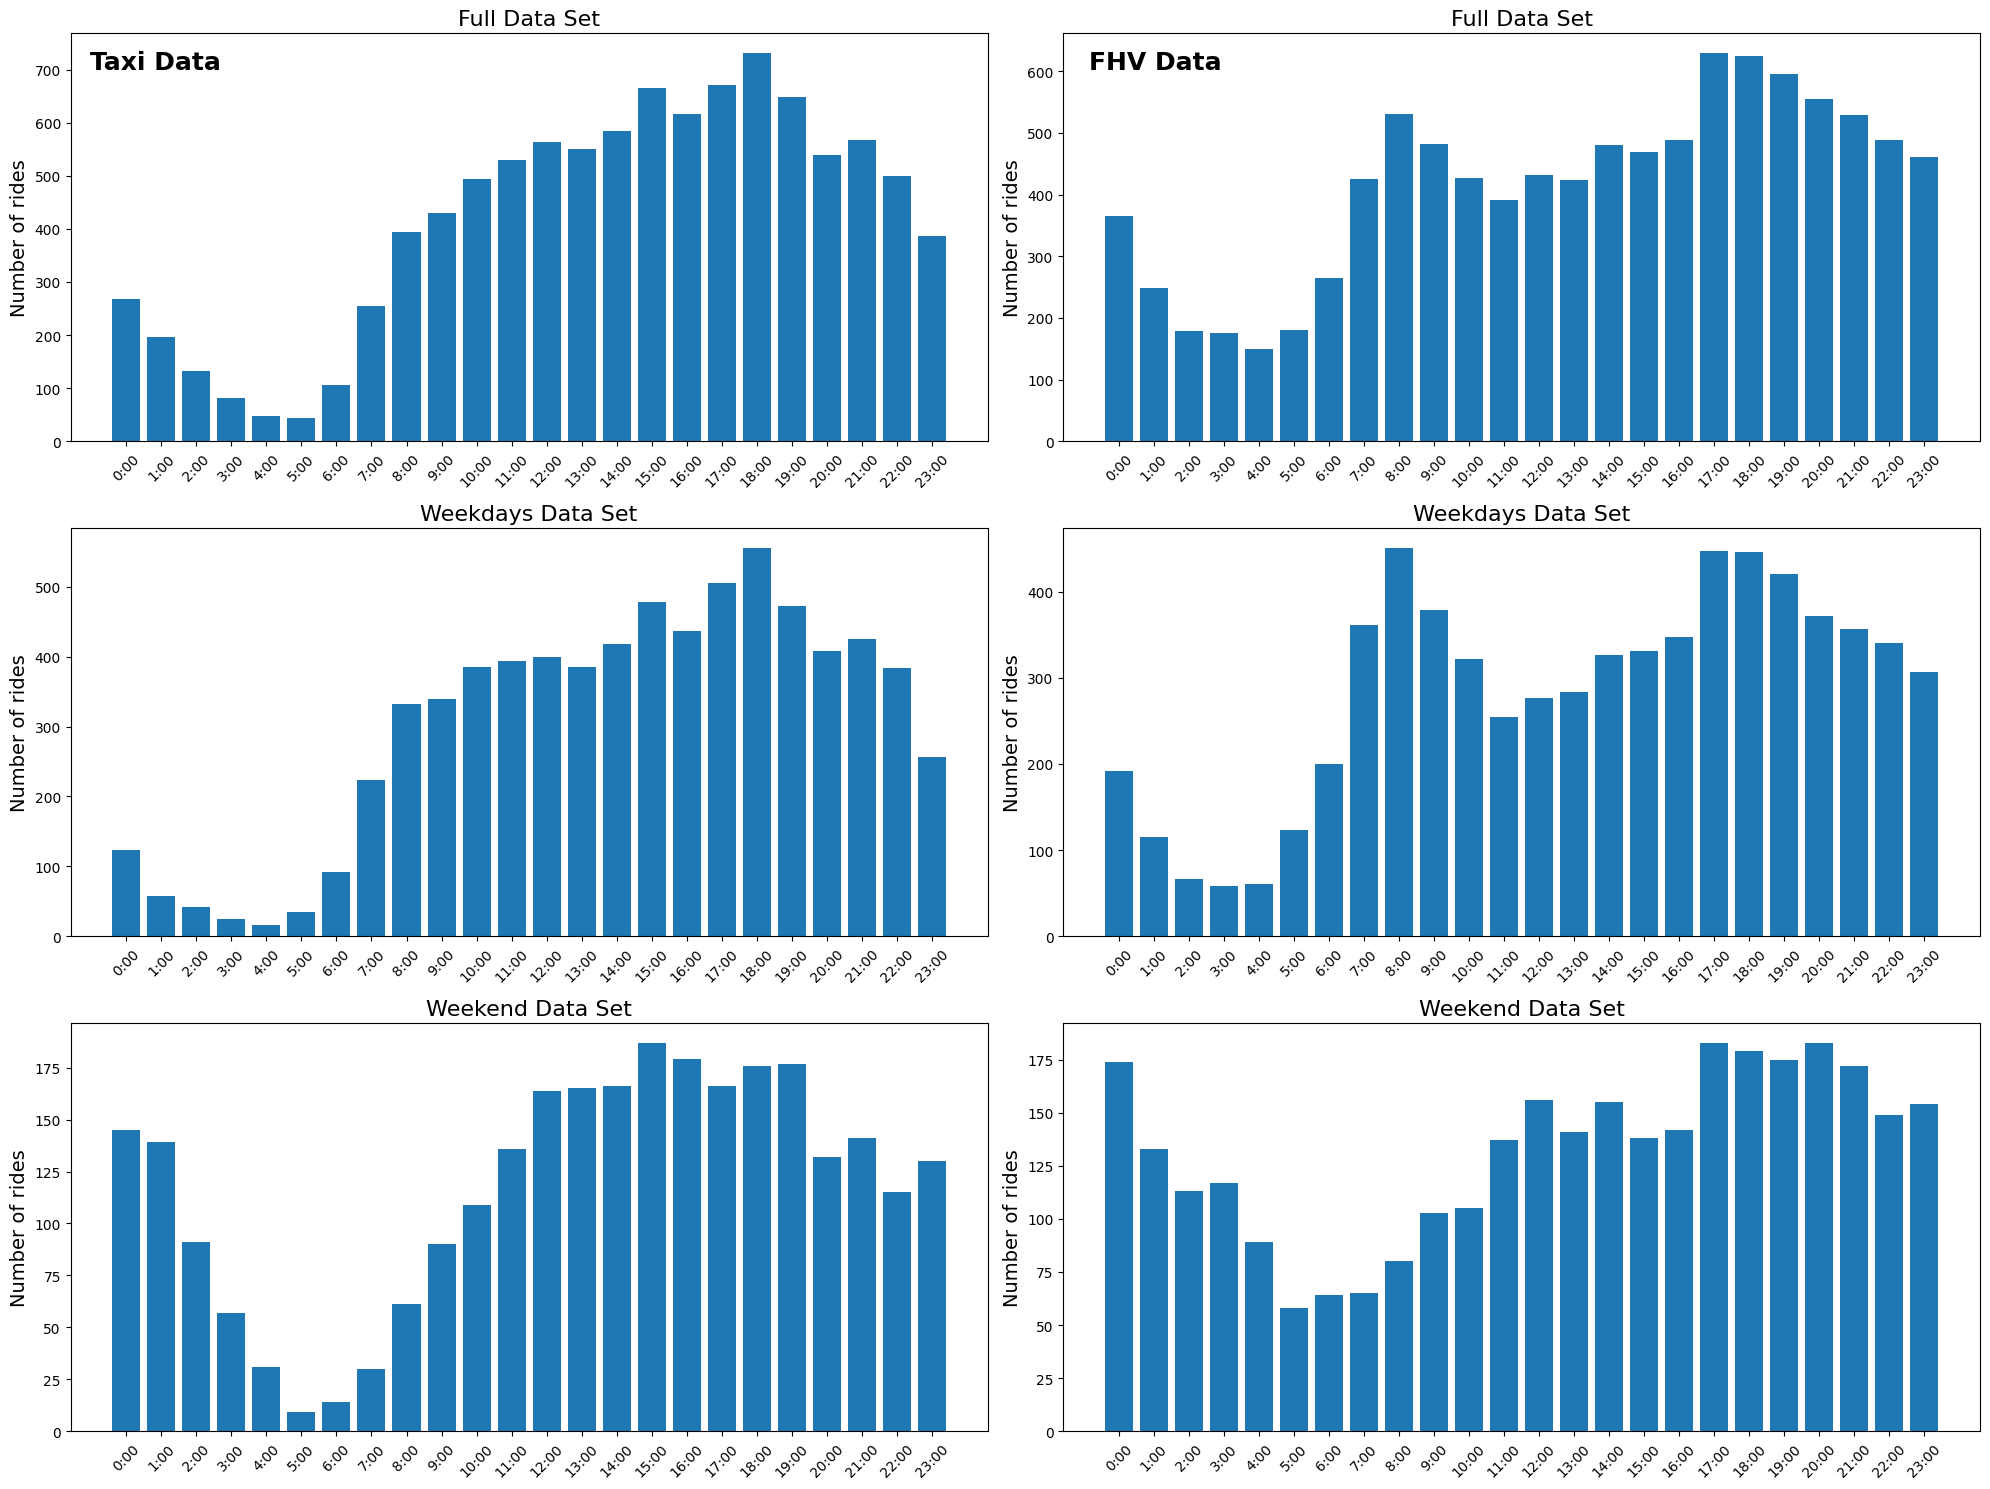

In [460]:
fig, ax = plt.subplots(3,2, figsize=(20,15))
#Hourly utility of taxis on full dataset
ax[0][0].bar(hour_utilization_taxi.index, hour_utilization_taxi)
ax[0][0].set_title('Full Data Set', fontsize=16)
ax[0][0].set_ylabel('Number of rides', fontsize=14)
x_ticks = [f"{hour}:00" for hour in hour_utilization_taxi.index]
ax[0][0].set_xticks(hour_utilization_taxi.index)
ax[0][0].set_xticklabels(x_ticks, rotation=45)

#Hourly utility of FHV on full dataset
ax[0][1].bar(hour_utilization_fhv.index, hour_utilization_fhv)
ax[0][1].set_title('Full Data Set', fontsize=16)
ax[0][1].set_ylabel('Number of rides', fontsize=14)
x_ticks = [f"{hour}:00" for hour in hour_utilization_fhv.index]
ax[0][1].set_xticks(hour_utilization_fhv.index)
ax[0][1].set_xticklabels(x_ticks, rotation=45)

#Hourly utility of taxis on weekdays 
ax[1][0].bar(hour_utilization_taxi_weekday.index, hour_utilization_taxi_weekday)
ax[1][0].set_title('Weekdays Data Set', fontsize=16)
ax[1][0].set_ylabel('Number of rides', fontsize=14)
x_ticks = [f"{hour}:00" for hour in hour_utilization_taxi_weekday.index]
ax[1][0].set_xticks(hour_utilization_taxi_weekday.index)
ax[1][0].set_xticklabels(x_ticks, rotation=45)

#Hourly utility of FHV on weekdays
ax[1][1].bar(hour_utilization_fhv_weekday.index, hour_utilization_fhv_weekday)
ax[1][1].set_title('Weekdays Data Set', fontsize=16)
ax[1][1].set_ylabel('Number of rides', fontsize=14)
x_ticks = [f"{hour}:00" for hour in hour_utilization_fhv_weekday.index]
ax[1][1].set_xticks(hour_utilization_fhv_weekday.index)
ax[1][1].set_xticklabels(x_ticks, rotation=45)

#Hourly utility of taxis on the weekend or holidays
ax[2][0].bar(hour_utilization_taxi_weekend.index, hour_utilization_taxi_weekend)
ax[2][0].set_title('Weekend Data Set', fontsize=16)
ax[2][0].set_ylabel('Number of rides', fontsize=14)
x_ticks = [f"{hour}:00" for hour in hour_utilization_taxi_weekend.index]
ax[2][0].set_xticks(hour_utilization_taxi_weekend.index)
ax[2][0].set_xticklabels(x_ticks, rotation=45)

#hourly utility of FHV on the weekend or holidays
ax[2][1].bar(hour_utilization_fhv_weekend.index, hour_utilization_fhv_weekend)
ax[2][1].set_title('Weekend Data Set', fontsize=16)
ax[2][1].set_ylabel('Number of rides', fontsize=14)
x_ticks = [f"{hour}:00" for hour in hour_utilization_fhv_weekend.index]
ax[2][1].set_xticks(hour_utilization_fhv_weekend.index)
ax[2][1].set_xticklabels(x_ticks, rotation=45)

fig.text(0.08, 0.95, 'Taxi Data', ha='center', fontsize=18, fontweight='bold')
fig.text(0.58, 0.95, 'FHV Data', ha='center', fontsize=18, fontweight='bold')

fig.tight_layout()

plt.savefig('hour_utilization_analysis.png')

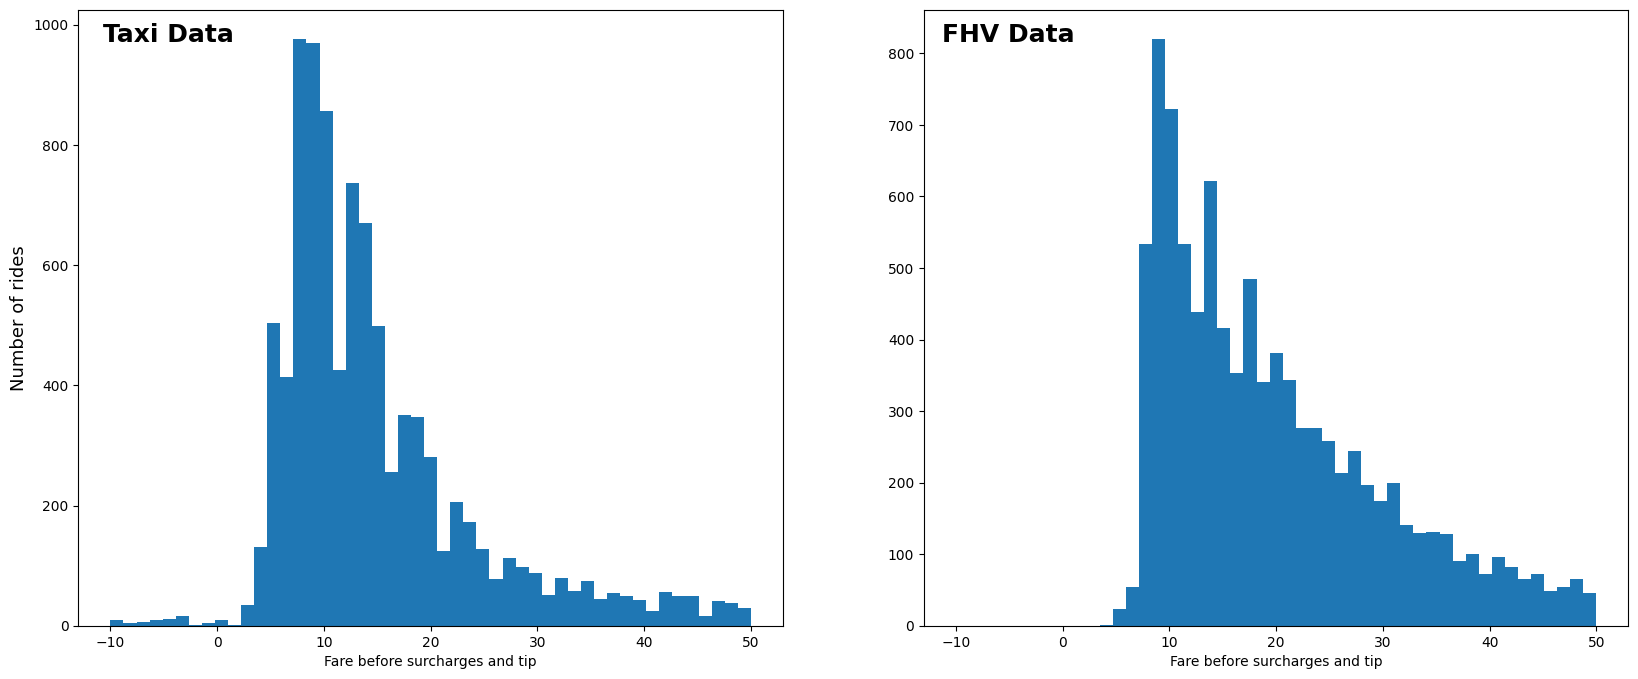

In [461]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].hist(taxi_data['fare_amount'], bins=np.linspace(-10,50))
axs[0].set_xlabel('Fare before surcharges and tip')
axs[0].set_ylabel('Number of rides', fontsize=13)

axs[1].hist(rideshare_data['base_passenger_fare'], bins=np.linspace(-10,50))
axs[1].set_xlabel('Fare before surcharges and tip')

fig.text(0.17, 0.84, 'Taxi Data', ha='center', fontsize=18, fontweight='bold')
fig.text(0.59, 0.84, 'FHV Data', ha='center', fontsize=18, fontweight='bold')

plt.savefig('fare_histogram.png')


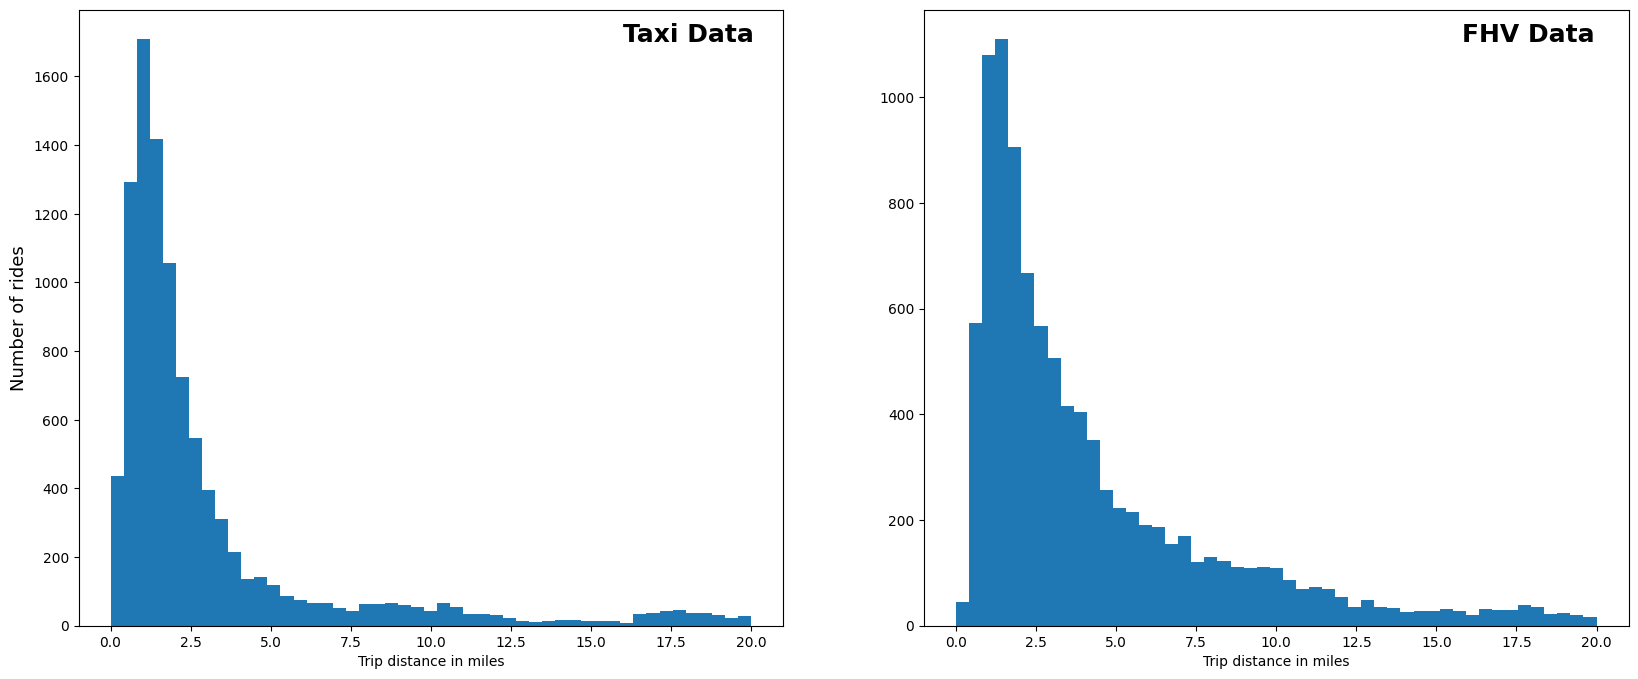

In [462]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].hist(taxi_data['trip_distance'], bins=np.linspace(0,20))
axs[0].set_xlabel('Trip distance in miles')
axs[0].set_ylabel('Number of rides', fontsize=13)

axs[1].hist(rideshare_data['trip_miles'], bins=np.linspace(0,20))
axs[1].set_xlabel('Trip distance in miles')

fig.text(0.43, 0.84, 'Taxi Data', ha='center', fontsize=18, fontweight='bold')
fig.text(0.85, 0.84, 'FHV Data', ha='center', fontsize=18, fontweight='bold')

plt.savefig('distance_histogram.png')

In [463]:
# 1 - Newark Airport
# 132 - JFK Airport 
# 138 - LaGuardia Airport

taxi_data[taxi_data['DOLocationID'].isin([1,132,138])].groupby(by='DOLocationID').agg({
    'trip_distance' : ['mean', 'count']
})

trip_distance      
                      mean count
DOLocationID                    
1                15.960000    28
132              13.800187   107
138              10.245556   108

In [464]:
rideshare_data[rideshare_data['DOLocationID'].isin([1,132,138])].groupby(by='DOLocationID').agg({
    'trip_miles' : ['mean', 'count']
})

trip_miles      
                   mean count
DOLocationID                 
1             18.129491    55
132           13.333376   213
138            9.369805   190

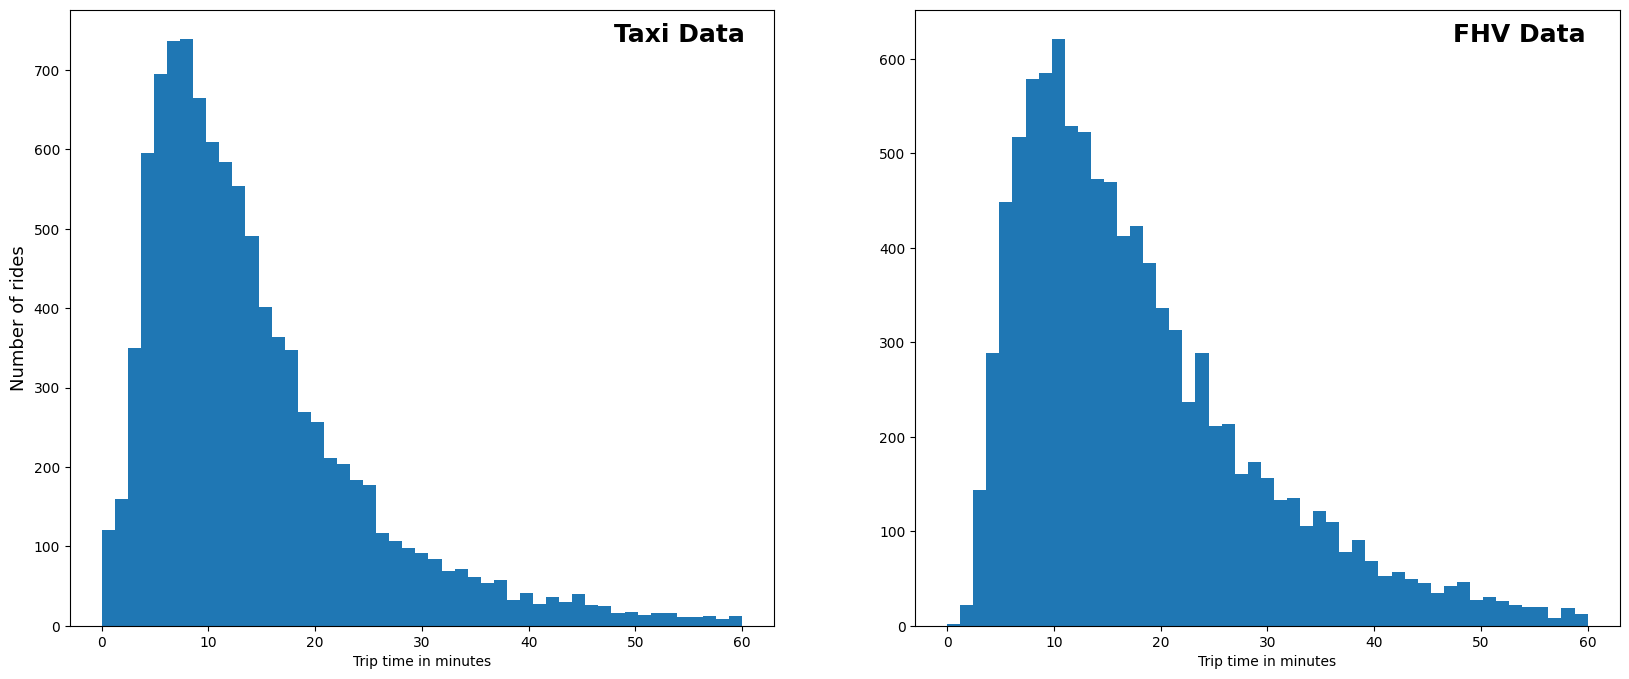

In [466]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

taxi_data['time'] = taxi_data['time'].dt.total_seconds()/60
rideshare_data['trip_time'] = rideshare_data['trip_time'].dt.total_seconds()/60

axs[0].hist(taxi_data['time'], bins=np.linspace(0,60))
axs[0].set_xlabel('Trip time in minutes')
axs[0].set_ylabel('Number of rides', fontsize=13)

axs[1].hist(rideshare_data['trip_time'], bins=np.linspace(0,60))
axs[1].set_xlabel('Trip time in minutes')

fig.text(0.43, 0.84, 'Taxi Data', ha='center', fontsize=18, fontweight='bold')
fig.text(0.85, 0.84, 'FHV Data', ha='center', fontsize=18, fontweight='bold')

plt.savefig('time_histogram.png')

Talk about airport distance and distributions. How well can we predict price from miles and time?

In [467]:
taxi_price_length = taxi_data.loc[:,['time','trip_distance','fare_amount']]

taxi_price_length = taxi_price_length[taxi_price_length['fare_amount'] > 0]
#taxi_price_length = taxi_price_length[taxi_price_length['fare_amount'] < 100]

corr_matrix = taxi_price_length.corr()

corr_matrix

,time,trip_distance,fare_amount
time,1.000000,0.500995,0.498460
trip_distance,0.500995,1.000000,0.913146
fare_amount,0.498460,0.913146,1.000000


In [468]:
fhv_price_length = rideshare_data.loc[:,['trip_miles','trip_time', 'base_passenger_fare']]

fhv_price_length = fhv_price_length[fhv_price_length['base_passenger_fare'] < 100]

corr_matrix = fhv_price_length.corr()

corr_matrix

,trip_miles,trip_time,base_passenger_fare
trip_miles,1.000000,0.786294,0.857007
trip_time,0.786294,1.000000,0.803781
base_passenger_fare,0.857007,0.803781,1.000000


In [469]:
time_dist = taxi_price_length.loc[:,['trip_distance','time']]
fare = taxi_price_length['fare_amount']

time_dist_train, time_dist_test, fare_train, fair_test = train_test_split(time_dist, fare, test_size=0.2, random_state=0)

lm = LinearRegression()
lm.fit(time_dist_train, fare_train)

y_pred = lm.predict(time_dist_test)

r_squared = r2_score(y_pred, fair_test)
mse_lm = mean_squared_error(y_pred, fair_test)

print(r_squared, mse_lm)
print(lm.intercept_, lm.coef_)

0.8584768107631657 34.2906415146681
6.429237636196122 [3.59973509 0.0426174 ]


In [470]:
time_dist = fhv_price_length.loc[:,['trip_miles','trip_time']]
fare = fhv_price_length['base_passenger_fare']

time_dist_train, time_dist_test, fare_train, fair_test = train_test_split(time_dist, fare, test_size=0.2, random_state=0)

lm = LinearRegression()
lm.fit(time_dist_train, fare_train)

y_pred = lm.predict(time_dist_test)

r_squared = r2_score(y_pred, fair_test)
mse_lm = mean_squared_error(y_pred, fair_test)

print(r_squared, mse_lm)
print(lm.intercept_, lm.coef_)

0.7463396506356734 46.96318818595473
6.134655392194706 [1.97171648 0.41461119]


In [471]:
fare.sort_values(ascending=False)

11575051    99.92
13333569    99.74
15089326    99.63
15301626    99.53
3935682     99.37
            ...  
2832373      5.42
481664       5.39
1136864      5.39
5641413      5.18
15158020     4.11
Name: base_passenger_fare, Length: 9874, dtype: float64

Hmm this seems quite low? Are there extreme outliers or is it just this bad? Probably bigger analysis in section 4. Quite significantly better for fhv than for taxis. Why is that? Maybe outliers, maybe its not linear? We will see. 

In [472]:
taxi_grouped_PU_Location = taxi_data.groupby(by='PULocationID').agg({
'trip_distance' : ['mean','std','count'],
'time'          : ['mean','std'],
'total_amount'  : ['mean','std']
})

taxi_grouped_PU_Location

trip_distance                       time            total_amount  \
                      mean       std count       mean        std         mean   
PULocationID                                                                    
1                 0.000000       NaN     1   0.083333        NaN   132.500000   
4                 2.453571  2.073101    14  21.142857  17.851942    29.472143   
7                 1.714000  2.128814    10  10.213333  13.163984    20.449000   
9                10.800000       NaN     1  51.333333        NaN    44.000000   
10               16.450000  4.412346     2  38.266667   6.599663    89.985000   
...                    ...       ...   ...        ...        ...          ...   
261               4.293000  3.999613    40  22.040417  28.025771    30.467500   
262               2.704101  3.399488   139  12.162830   7.350089    23.024245   
263               2.243412  3.023013   211  10.664297   8.826495    20.986588   
264               2.303333  3.325992    42  10.503175   9.265298    28.801667   
265              10.745000  8.293477     4  12.170833  12.122510  -106.565000   

                          
                     std  
PULocationID              
1                    NaN  
4              14.034877  
7              28.280082  
9                    NaN  
10              1.350574  
...                  ...  
261            16.283014  
262            14.920702  
263            16.353666  
264            25.023357  
265           317.283393  

[155 rows x 7 columns]

In [473]:
taxi_grouped_DO_Location = taxi_data.groupby(by='DOLocationID').agg({
'trip_distance' : ['mean','std','count'],
'time'          : ['mean','std'],
'total_amount'  : ['mean','std']
})

taxi_grouped_DO_Location

trip_distance                        time             \
                      mean        std count       mean        std   
DOLocationID                                                        
1                15.960000   5.124709    28  33.645833  10.227679   
3                 2.200000        NaN     1  32.183333        NaN   
4                 2.198222   1.954597    45  12.643333   6.833977   
7                 3.961667   2.892892    24  18.274306  10.066404   
10                8.054167   8.569726    12  18.305556  12.953472   
...                    ...        ...   ...        ...        ...   
261               4.148919   4.032578    37  17.309910   9.475979   
262               2.608424   3.258282   165  12.572020   8.918247   
263               2.500226   2.873458   221  11.768477   7.922508   
264               2.465000   3.553075    46  12.028261  10.756534   
265              19.083000  13.178292    40  35.959583  19.143271   

             total_amount              
                     mean         std  
DOLocationID                           
1              119.177500   12.710588  
3               21.000000         NaN  
4               21.212889   12.334068  
7               27.012917   17.765952  
10              42.222500   36.369200  
...                   ...         ...  
261             25.923784   23.213052  
262             23.521273   17.882452  
263             23.702805   16.036446  
264             31.611522   27.539586  
265            105.652250  137.419916  

[211 rows x 7 columns]

In [474]:
taxi_grouped_DOcount = taxi_grouped_DO_Location[('trip_distance','count')]
taxi_grouped_PUcount = taxi_grouped_PU_Location[('trip_distance','count')]

taxi_grouped_count = pd.DataFrame({
    'count_DO' : taxi_grouped_DOcount,
    'count_PU' : taxi_grouped_PUcount
}).fillna(0.)

taxi_grouped_count['count_difference'] = taxi_grouped_count['count_DO'] - taxi_grouped_count['count_PU']
taxi_grouped_count.sort_values(by ='count_difference', inplace=True)

taxi_grouped_count

,count_DO,count_PU,count_difference
132,107.0,450.0,-343.0
138,108.0,319.0,-211.0
161,365.0,503.0,-138.0
186,200.0,327.0,-127.0
249,151.0,235.0,-84.0
...,...,...,...
232,52.0,6.0,46.0
238,263.0,217.0,46.0
50,109.0,60.0,49.0
246,207.0,157.0,50.0


In [475]:
fhv_grouped_DOcount = rideshare_data.groupby(by='PULocationID').agg({
    'trip_miles' : ['count']
})[('trip_miles','count')]

fhv_grouped_PUcount = rideshare_data.groupby(by='DOLocationID').agg({
    'trip_miles' : ['count']
})[('trip_miles','count')]

fhv_grouped_count = pd.DataFrame({
    'count_DO' : fhv_grouped_DOcount,
    'count_PU' : fhv_grouped_PUcount
}).fillna(0.)

fhv_grouped_count['count_difference'] = fhv_grouped_count['count_DO'] - fhv_grouped_count['count_PU']
fhv_grouped_count.sort_values(by ='count_difference', inplace=True)

fhv_grouped_count

,count_DO,count_PU,count_difference
265,0.0,411.0,-411.0
1,0.0,55.0,-55.0
170,89.0,117.0,-28.0
37,97.0,125.0,-28.0
132,186.0,213.0,-27.0
...,...,...,...
113,74.0,44.0,30.0
246,129.0,97.0,32.0
249,116.0,81.0,35.0
230,135.0,94.0,41.0


In [476]:
location_lookup = pd.read_csv('taxi_zone_lookup.csv')

location_lookup

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [477]:
rideshare_data['response_time'] = (rideshare_data['on_scene_datetime'] - rideshare_data['request_datetime']).dt.total_seconds()/60

rideshare_response_grouped = rideshare_data.groupby(by='hour').agg({
'response_time' : ['mean','std','count']
})

rideshare_response_grouped

response_time                
              mean       std count
hour                              
0         3.843462  2.944672   260
1         3.939687  3.140383   181
2         3.697521  2.888048   121
3         3.537356  4.710325   116
4         3.358081  4.297393    99
5         2.604487  4.641908   130
6         3.435083  3.378313   181
7         3.831556  3.565438   300
8         3.466244  4.283244   394
9         2.680256  3.459875   352
10        1.962946  4.298204   336
11        2.449245  3.028925   287
12        2.754896  2.026577   337
13        2.330221  3.913104   332
14        2.467608  3.705685   354
15        2.996860  2.211079   345
16        2.699364  2.686423   367
17        3.028628  2.769277   464
18        2.930741  2.700058   450
19        2.821697  2.490080   434
20        2.702930  2.242824   421
21        2.977213  2.244317   403
22        3.248333  2.594779   370
23        3.653876  2.714648   344

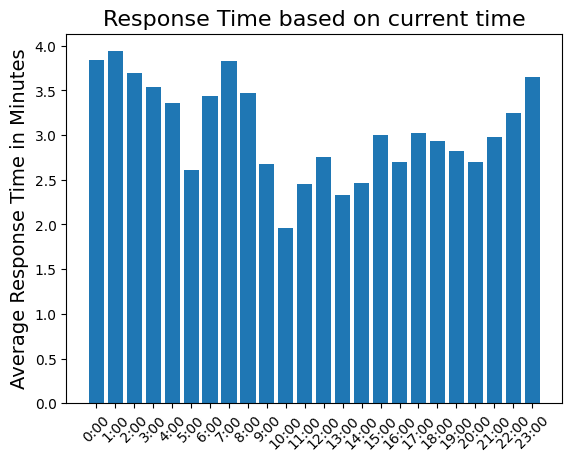

In [478]:
fig, ax = plt.subplots()

ax.bar(rideshare_response_grouped.index, rideshare_response_grouped['response_time']['mean'])
ax.set_title('Response Time based on current time', fontsize=16)
ax.set_ylabel('Average Response Time in Minutes', fontsize=14)
x_ticks = [f"{hour}:00" for hour in rideshare_response_grouped.index]
ax.set_xticks(rideshare_response_grouped.index)
ax.set_xticklabels(x_ticks, rotation=45)

plt.savefig('response_time_hour.png')

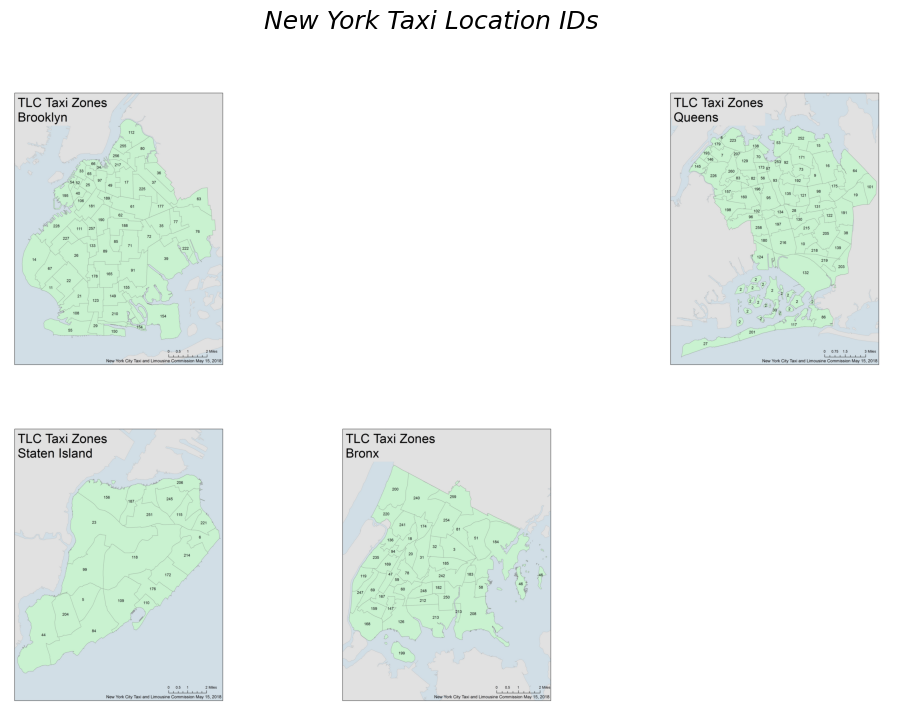

In [483]:
taxi_zones_brooklyn = Image.open("taxi_zone_map_brooklyn.jpg")
# taxi_zones_manhattan = Image.open("taxi_zone_map_manhattan.jpg")
taxi_zones_queens = Image.open("taxi_zone_map_queens.jpg")
taxi_zones_staten_island = Image.open("taxi_zone_map_staten_island.jpg")
taxi_zones_bronx = Image.open("taxi_zone_map_bronx.jpg")

fig, axs = plt.subplots(2,3, figsize=(12,8))
axs[0,0].imshow(taxi_zones_brooklyn)
axs[0,0].axis('off')

# axs[0,1].imshow(taxi_zones_manhattan)
axs[0,1].axis('off')

axs[0,2].imshow(taxi_zones_queens)
axs[0,2].axis('off')

axs[1,0].imshow(taxi_zones_staten_island)
axs[1,0].axis('off')

axs[1,1].imshow(taxi_zones_bronx)
axs[1,1].axis('off')

axs[1,2].axis('off')

fig.suptitle('New York Taxi Location IDs', fontsize = 18, style='oblique')

plt.savefig('new_york_location_ids.png')

In [484]:
rideshare_response_grouped = rideshare_data.groupby(by='PULocationID').agg({
'response_time' : ['mean','std','count']
})

rideshare_response_grouped.sort_values(('response_time','mean')).dropna()

response_time                 
                      mean        std count
PULocationID                               
146              -0.599074   9.131817    18
192               0.175000   8.591755    12
193               0.840909   7.008912    11
66                1.050000   6.450280    18
118               1.420000   0.957093     5
...                    ...        ...   ...
201               6.858333   1.237437     2
194               7.000000   1.461354     2
12                7.841667   6.493597     2
109               8.008333   7.103787     4
34               10.597917  17.442790     8

[239 rows x 3 columns]

In [485]:
#taxi_data['Airport_fee'].value_counts()
#taxi_data['congestion_surcharge'].value_counts()
#taxi_data['extra'].value_counts()
#taxi_data['improvement_surcharge'].value_counts()
#taxi_data['mta_tax'].value_counts()
#taxi_data['tolls_amount'].value_counts()

#rideshare_data['airport_fee'].value_counts()
#rideshare_data['congestion_surcharge'].value_counts()
#rideshare_data['bcf'].value_counts()
#rideshare_data['sales_tax'].value_counts()
rideshare_data['tolls'].value_counts()

# frac_airport = (756 + 24 + 759 + 16 + 5)/2*n
# frac_airport

# frac_congestion = (8660 + 104 + 3904 + 148 + 20)/(2*n)
# frac_congestion

# tolls_frac = (725 + 1288)/(2*n)
# tolls_frac

tolls
0.00     8712
6.94      554
20.00     106
21.00      24
3.18       21
         ... 
2.06        1
6.46        1
3.75        1
22.25       1
21.28       1
Name: count, Length: 376, dtype: int64

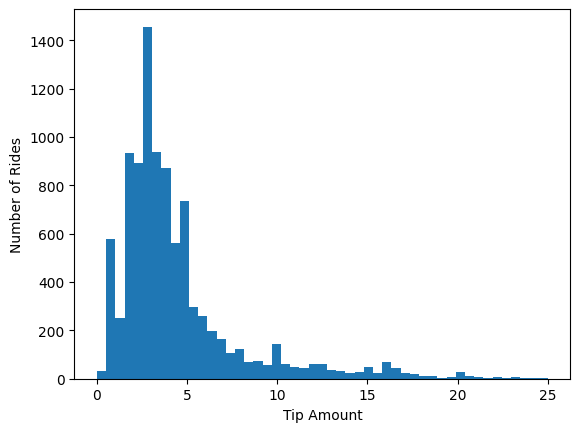

In [486]:
tips = pd.concat([taxi_data['tip_amount'], rideshare_data['tips']]) 
tips = tips[tips != 0]

fig, ax = plt.subplots()

ax.hist(tips.values, bins=np.linspace(0,25))
ax.set_xlabel('Tip Amount')
ax.set_ylabel('Number of Rides')

plt.savefig('tip_histogram.png')

# Hypothesis Testing 

### 1. Are taxis more expensive than FHvs?

In [489]:
n = 10000

taxi_data = taxi.sample(n, random_state=0)
rideshare_data = rideshare.sample(n, random_state=0)

In [490]:
taxi_data_pos = taxi_data[(taxi_data['fare_amount'] > 0) & (taxi_data['fare_amount'] < 100)]
taxi_data_pos = taxi_data_pos[(taxi_data_pos['trip_distance'] > 0.3) & (taxi_data_pos['trip_distance'] < 50)]
taxi_data_cost = taxi_data_pos['total_amount']/taxi_data_pos['trip_distance']

rideshare_data_pos = rideshare_data[(rideshare_data['base_passenger_fare'] > 0) & (rideshare_data['base_passenger_fare'] < 100)]
rideshare_data_pos['total_amount'] = rideshare_data_pos['base_passenger_fare'] + rideshare_data_pos['tolls'] + rideshare_data_pos['bcf'] + rideshare_data_pos['sales_tax'] 
+ rideshare_data_pos['congestion_surcharge'] + rideshare_data_pos['airport_fee']
rideshare_data_pos = rideshare_data_pos[(rideshare_data_pos['trip_miles'] > 0.3) & (rideshare_data['trip_miles'] < 50)]
rideshare_data_cost = rideshare_data_pos['total_amount']/rideshare_data_pos['trip_miles']

taxi_data_cost_mean = taxi_data_cost.mean()
taxi_data_cost_std = taxi_data_cost.std()
rideshare_data_cost_mean = rideshare_data_cost.mean()
rideshare_data_cost_std = rideshare_data_cost.std()

n_x = len(taxi_data_cost)
n_y = len(rideshare_data_cost)

print(taxi_data_cost_mean,taxi_data_cost_std, rideshare_data_cost_mean, rideshare_data_cost_std)

t_obs = (taxi_data_cost_mean-rideshare_data_cost_mean)/np.sqrt(taxi_data_cost_std**2/n_x+rideshare_data_cost_std**2/n_y)
df = ((taxi_data_cost_std**2/n_x+rideshare_data_cost_std**2/n_y)**2)/((taxi_data_cost_std**2/n_x)**2/(n_x-1)+(rideshare_data_cost_std/n_y)**2/(n_y-1))

p_value = 2*np.min([stats.t.cdf(t_obs, df),1-stats.t.cdf(t_obs, df)])

print(df)
print(t_obs, p_value)

12.44240082709477 5.809479441813711 7.98025801885264 4.577440080266551
24052.00764131274
59.28849722372443 0.0


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_22024\3494180933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rideshare_data_pos['total_amount'] = rideshare_data_pos['base_passenger_fare'] + rideshare_data_pos['tolls'] + rideshare_data_pos['bcf'] + rideshare_data_pos['sales_tax']
C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_22024\3494180933.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rideshare_data_pos = rideshare_data_pos[(rideshare_data_pos['trip_miles'] > 0.3) & (rideshare_data['trip_miles'] < 50)]


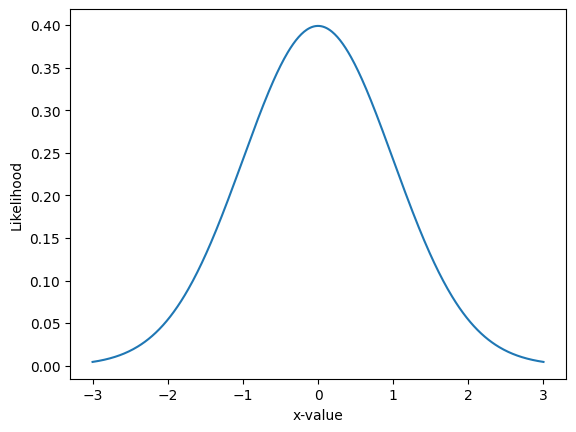

In [491]:
x = np.linspace(-3, 3, 500)
t_dist = stats.t.pdf(x, df)

fig, ax = plt.subplots()

ax.plot(x, t_dist)
ax.set_xlabel('x-value')
ax.set_ylabel('Likelihood')

plt.savefig('hyp1_t_distribution.png')

In [492]:
#Sanity check if the surcharge add on works
rideshare_data_pos.loc[:,['base_passenger_fare','total_amount']]

,base_passenger_fare,total_amount
6891938,45.96,51.30
16641657,15.50,17.31
18267380,23.46,26.19
12041742,24.65,26.93
8350717,8.90,9.93
...,...,...
593047,8.02,8.95
9495407,18.76,20.94
14306825,20.58,22.98
19268700,14.26,15.92


In [493]:
#Shared rides suspicion 
rideshare_data_pos['shared_match_flag'].value_counts()

shared_match_flag
N    9715
Y     138
Name: count, dtype: int64

### 2. Do Car surpluses or lacks get equalized by the two data sets?

In [494]:
mixed_grouped_DO_PU = pd.concat([taxi_grouped_count['count_difference'], fhv_grouped_count['count_difference']], axis=1).fillna(0)
mixed_grouped_DO_PU.columns = ['diff_taxi','diff_fhv']
mixed_grouped_DO_PU_sig = mixed_grouped_DO_PU[(np.abs(mixed_grouped_DO_PU['diff_taxi']) > 9) & (np.abs(mixed_grouped_DO_PU['diff_fhv']) > 9)] 

mixed_grouped_DO_PU_sig = mixed_grouped_DO_PU_sig.applymap(np.sign)
mixed_grouped_DO_PU_sig.groupby(by=['diff_taxi','diff_fhv']).size()


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_22024\1478463574.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mixed_grouped_DO_PU_sig = mixed_grouped_DO_PU_sig.applymap(np.sign)


diff_taxi  diff_fhv
-1.0       -1.0         4
            1.0        10
 1.0       -1.0         9
            1.0        11
dtype: int64

In [495]:
n_sl = 9
n_ls = 10

#discordance = np.min([n_hn/(n_hn+n_nh), n_nh/(n_hn+n_nh)])
#H_0 : discordance = 0.5 (no pattern in the movement between groups)

s_obs = np.min([n_sl, n_ls])

p_value = stats.binom.cdf(s_obs, n_sl + n_ls, 0.5)

p_value

np.float64(0.5)

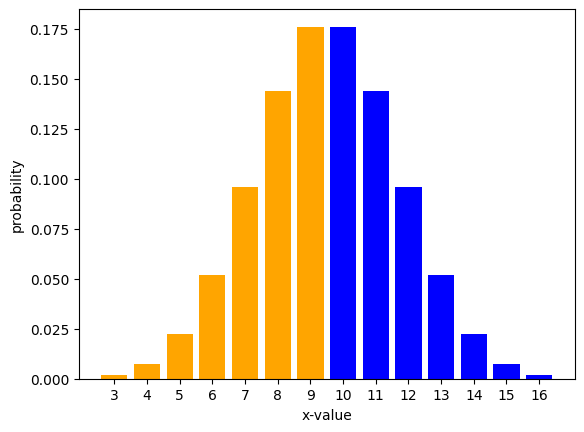

In [496]:
x = range(3, 17)
bin_dist = stats.binom.pmf(x, n_sl + n_ls, 0.5)

fig, ax = plt.subplots()

ax.bar(x, bin_dist, color = ['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 
                             'blue','blue','blue','blue','blue','blue','blue'])
ax.set_xticks(x)
ax.set_xlabel('x-value')
ax.set_ylabel('probability')

plt.savefig('hyp2_binom_distribution.png')

### 3. Does the amount of surcharges paid change the number of tips?

In [497]:
taxi_data_tip_filtered = taxi_data[(taxi_data['payment_type'] == 1) & (taxi_data['fare_amount'] > 0)]
fhv_data_tip_filtered = rideshare_data[rideshare_data['base_passenger_fare'] > 0]

tips_full = pd.concat([taxi_data_tip_filtered['tip_amount'], fhv_data_tip_filtered['tips']])

In [498]:
len(tips_full_surcharged)

11349

In [499]:
#taxi_data_tip_filtered_surcharges = taxi_data_tip_filtered[(taxi_data_tip_filtered['Airport_fee'] > 0) | (taxi_data_tip_filtered['tolls_amount'] > 0)]
#fhv_data_tip_filtered_surcharges = fhv_data_tip_filtered[(fhv_data_tip_filtered['airport_fee'] > 0) | (fhv_data_tip_filtered['tolls'] > 0)]

# taxi_data_tip_filtered_surcharges = taxi_data_tip_filtered[(taxi_data_tip_filtered['tolls_amount'] > 0)]
# fhv_data_tip_filtered_surcharges = fhv_data_tip_filtered[(fhv_data_tip_filtered['tolls'] > 0)]

taxi_data_tip_filtered_surcharges = taxi_data_tip_filtered[(taxi_data_tip_filtered['congestion_surcharge'] > 0)]
fhv_data_tip_filtered_surcharges = fhv_data_tip_filtered[(fhv_data_tip_filtered['congestion_surcharge'] > 0)]

tips_full_surcharged = pd.concat([taxi_data_tip_filtered_surcharges['tip_amount'], fhv_data_tip_filtered_surcharges['tips']])


In [500]:
mean_tips_full = tips_full.mean()
mean_tips_surcharged = tips_full_surcharged.mean()

print(mean_tips_full, mean_tips_surcharged)

std_tips_surcharged = tips_full_surcharged.std()

n = len(tips_full_surcharged)

t_obs = (mean_tips_surcharged - mean_tips_full)/(std_tips_surcharged/np.sqrt(n))

p_value = 2*min(stats.t.cdf(t_obs, n-1), 1-stats.t.cdf(t_obs, n-1))

t_obs

2.4176885890949973 3.0750630011454754


np.float64(19.802227902816576)

# Machine Learning

### K-means

In [501]:
taxi_trip_locations = taxi_data.groupby(by=['PULocationID', 'DOLocationID']).size().reset_index()
rideshare_trip_location = rideshare_data.groupby(by=['PULocationID', 'DOLocationID']).size().reset_index()

joined_trip_location = pd.merge(taxi_trip_locations, rideshare_trip_location, on=['PULocationID', 'DOLocationID'], how='outer').fillna(0)
joined_trip_location['occurance'] = (joined_trip_location['0_x'] + joined_trip_location['0_y'])
joined_trip_location.drop(['0_x','0_y'], axis=1, inplace=True)
joined_trip_location = joined_trip_location[joined_trip_location['occurance'] > 15]

all_locations_relevant = list(set(joined_trip_location['DOLocationID']) | set(joined_trip_location['PULocationID']))

location_movement_matrix = pd.DataFrame(0, index=all_locations_relevant, columns=all_locations_relevant)
j = 0
for i,row in joined_trip_location.iterrows():
    j += 1
    location_movement_matrix.at[row['DOLocationID'],row['PULocationID']] = row['occurance']

# zero_count = (location_movement_matrix == 0).sum().sum()
# print(j)
# print(63*63)
# print(zero_count)

location_movement_matrix


        

,132,262,7,263,137,265,138,140,141,142,...,229,230,234,107,236,237,238,239,246,249
132,31,0,0,0,0,0,0,0,0,0,...,0,17,0,0,0,0,0,0,0,0
262,0,0,0,0,0,0,0,21,0,0,...,0,0,0,0,28,16,0,0,0,0
7,0,0,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,0,0,0,17,0,0,0,16,18,0,...,0,0,0,0,21,0,0,0,0,0
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,46,0,0,0,0,0,37,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138,0,0,0,0,0,0,0,0,0,0,...,0,24,0,0,0,0,0,0,0,0
140,0,21,0,0,0,0,0,0,0,19,...,0,0,0,0,29,21,0,0,0,0
141,0,0,0,27,0,0,0,0,0,17,...,0,0,0,0,22,26,0,0,0,0
142,0,0,0,0,0,0,0,0,0,20,...,0,0,0,0,16,27,29,27,0,0


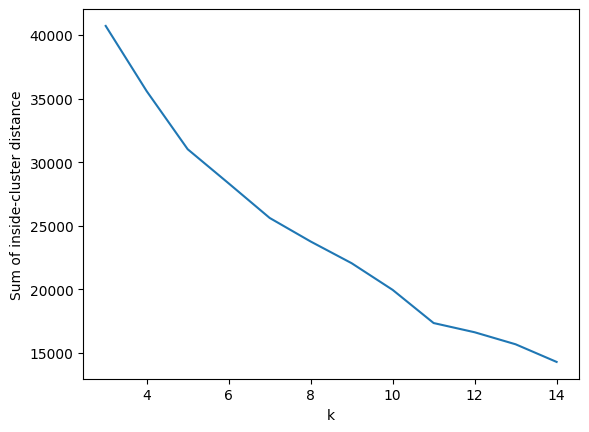

In [502]:
inertia = pd.Series(0, index=range(3,15), dtype=float)

for k in range(3,15):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(location_movement_matrix)
    inertia[k]=kmeans.inertia_
    if k == 8:
        labels_7 = pd.Series(kmeans.labels_, index=all_locations_relevant)
    if k == 5:
        labels_5 = pd.Series(kmeans.labels_, index=all_locations_relevant)

fig, ax = plt.subplots()

ax.plot(inertia.index, inertia)
ax.set_ylabel('Sum of inside-cluster distance')
ax.set_xlabel('k')

plt.savefig('k_means_k_eval.png')

In [503]:
df_labels = labels_5.reset_index()

df_labels.columns = ['LocationID', 'label']

df_labels

,LocationID,label
0,132,1
1,262,3
2,7,1
3,263,3
4,137,1
5,265,4
6,138,1
7,140,3
8,141,3
9,142,0


In [504]:
merged_location_labels = pd.merge(df_labels, location_lookup, on=['LocationID'], how='left')
merged_location_labels_grouped = merged_location_labels.groupby(by=['Borough','label']).size()
merged_location_labels_grouped

Borough    label
Brooklyn   1         4
Manhattan  0         3
           1        16
           2         2
           3         7
           4         1
Queens     1         4
Unknown    1         1
dtype: int64

In [505]:
joined_trip_location[joined_trip_location['PULocationID'] == 230]

,PULocationID,DOLocationID,occurance
5820,230,48,21.0
5825,230,68,23.0
5843,230,132,17.0
5845,230,138,24.0
5857,230,161,16.0
5866,230,186,22.0
5883,230,246,24.0


### Linear Regression

In [506]:
X_train, X_test = train_test_split(taxi_data_tip_filtered, test_size=0.2)

distance_predictions = X_train.groupby(by=['PULocationID','DOLocationID'])['trip_distance'].mean()
y_train = X_train['fare_amount']

X_train = X_train.loc[:,['PULocationID','DOLocationID']]

X_train['pred_distance'] = taxi_data.trip_distance.mean()
for i, row in X_train.iterrows():
    X_train.at[i, 'pred_distance'] = distance_predictions.at[row['PULocationID'],row['DOLocationID']]

# X_test = X_test.loc[:,['PULocationID','DOLocationID']]
# for i, row in X_test.iterrows():
#     X_test.at[i, 'pred_distance'] = distance_predictions.at[row['PULocationID'],row['DOLocationID']]

X_test

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2392625,2,2024-01-27 13:50:51,2024-01-27 14:01:52,1.0,1.59,1.0,N,162,186,1,12.1,0.0,0.5,3.22,0.0,1.0,19.32,2.5,0.00
600745,1,2024-01-08 11:27:14,2024-01-08 11:33:59,1.0,1.30,1.0,N,249,234,1,8.6,2.5,0.5,1.89,0.0,1.0,14.49,2.5,0.00
1479891,2,2024-01-17 21:22:46,2024-01-17 21:35:21,1.0,2.80,1.0,N,114,246,1,16.3,1.0,0.5,4.26,0.0,1.0,25.56,2.5,0.00
1865277,2,2024-01-21 22:19:10,2024-01-21 22:39:30,1.0,9.53,1.0,N,138,211,1,39.4,6.0,0.5,8.00,0.0,1.0,59.15,2.5,1.75
408023,2,2024-01-05 20:25:34,2024-01-05 20:35:31,2.0,2.20,1.0,N,161,141,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443307,2,2024-01-17 15:56:08,2024-01-17 16:08:47,1.0,1.52,1.0,N,186,113,1,12.8,0.0,0.5,3.36,0.0,1.0,20.16,2.5,0.00
1110466,2,2024-01-13 19:55:58,2024-01-13 20:12:53,1.0,2.76,1.0,N,237,238,1,17.7,0.0,0.5,2.50,0.0,1.0,24.20,2.5,0.00
1115335,2,2024-01-13 19:08:15,2024-01-13 19:20:13,1.0,1.49,1.0,N,234,246,1,12.1,0.0,0.5,3.22,0.0,1.0,19.32,2.5,0.00
1859127,2,2024-01-21 20:09:51,2024-01-21 20:15:29,1.0,0.82,1.0,N,48,48,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


In [507]:
lm = LinearRegression()

lm.fit(X_train, y_train)
y_pred = lm.predict(X_train)

print(r2_score(y_train, y_pred), mean_squared_error(y_train, y_pred))

print(lm.intercept_, lm.coef_)



0.8091357303015854 54.4687131097254
7.323381622877733 [-2.22785174e-03 -1.28345008e-03  3.63395913e+00]


"C:\GU\Term2\Statistical_Models_for_DS\Project\travel_2022.xlsx"